In [ ]:
!pip install numba==0.58.1
!pip install clifford
!pip install "numpy<2.0" numba==0.58.1

import clifford as cf

layout, blades = cf.Cl(3)

e1 = blades['e1']
e2 = blades['e2']
e3 = blades['e3']
e12 = blades['e12']
e13 = blades['e13']
e23 = blades['e23']
e123 = blades['e123']

  Using cached clifford-1.4.0-py3-none-any.whl.metadata (5.1 kB)
Using cached clifford-1.4.0-py3-none-any.whl (159 kB)


Calculating B-field magnitude over time...
  - Processing point: Center (0,0,0)


/usr/local/lib/python3.11/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


  - Processing point: On x-axis (R/2,0,0)
  - Processing point: Off-axis (0,R/2,R/2)


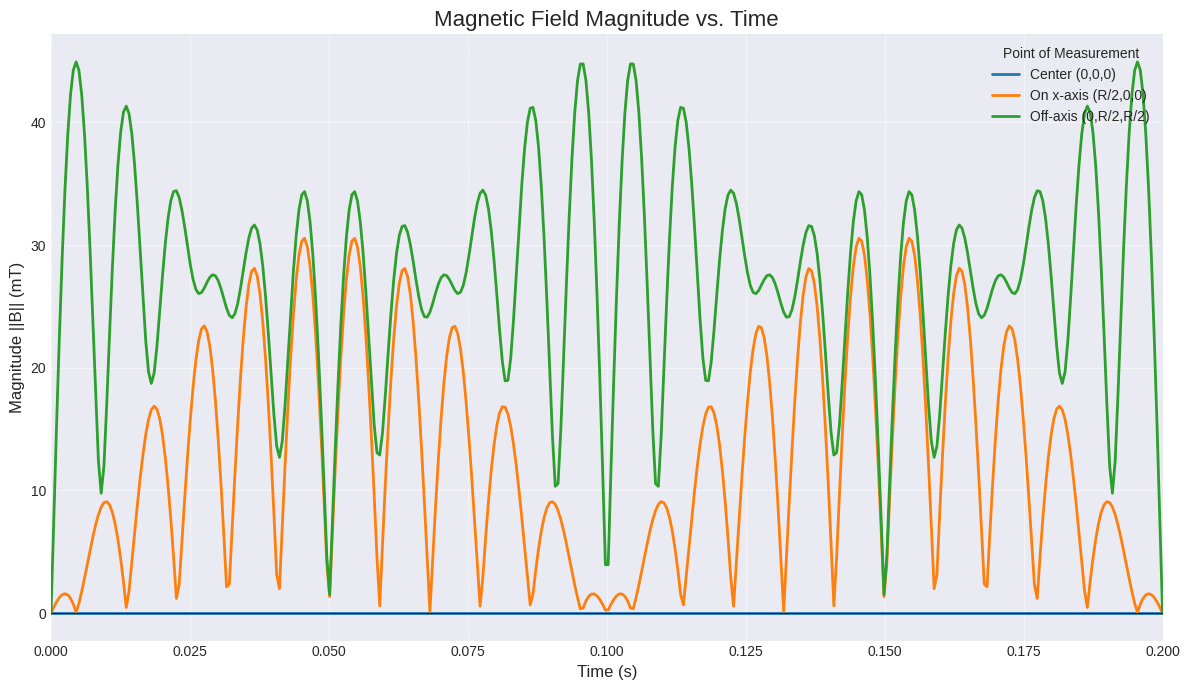


Calculating A-potential magnitude over time...
  - Processing point: Center (0,0,0)
  - Processing point: On x-axis (R/2,0,0)
  - Processing point: Off-axis (0,R/2,R/2)


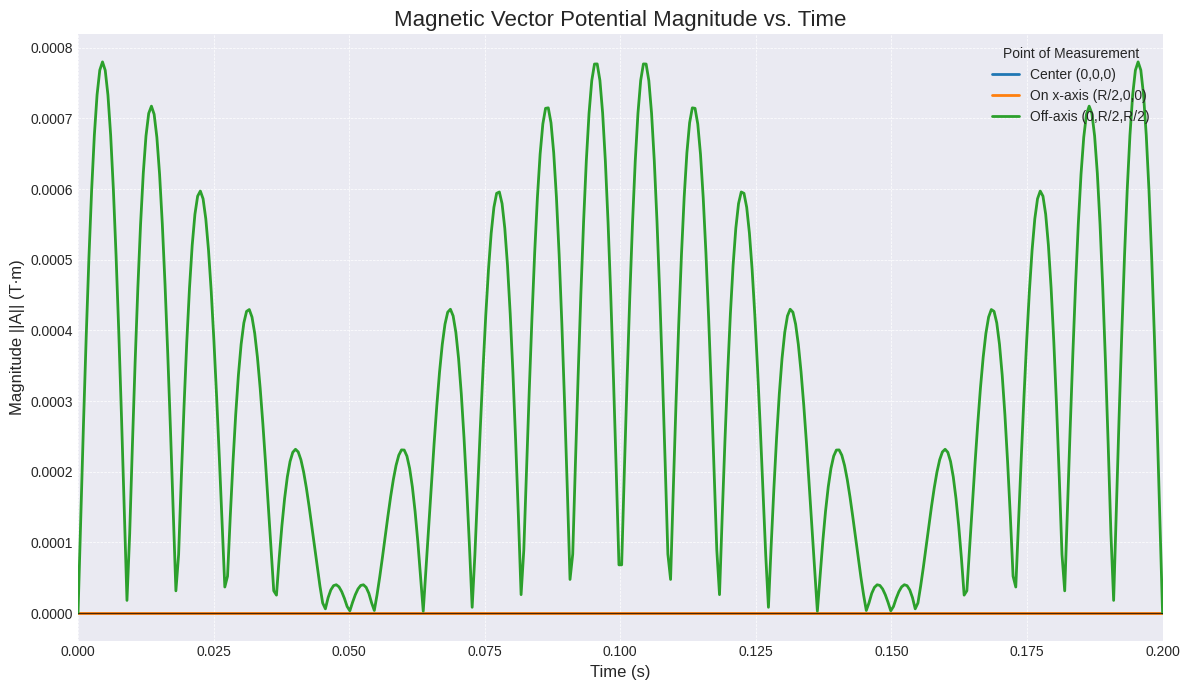

In [ ]:
# !pip install numba==0.58.1
# !pip install clifford
# !pip install "numpy<2.0"
# !pip install matplotlib scipy

import clifford as cf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec
from math import tau

# --- Physical Constants ---
# Vacuum permeability in T·m/A (or H/m), defined using tau
MU_0 = 2 * tau * 1e-7

# --- Waveform Definitions ---

def sine_wave(t, omega, phase, **kwargs):
    """A standard sine wave oscillating between -1 and 1."""
    return np.sin(omega * t + phase)

def sine_wave_dt(t, omega, phase, **kwargs):
    """The time derivative of the sine wave."""
    return omega * np.cos(omega * t + phase)

def square_wave(t, omega, phase, k=20.0, **kwargs):
    """A square wave approximated by a steep tanh function."""
    return np.tanh(k * np.sin(omega * t + phase))

def square_wave_dt(t, omega, phase, k=20.0, **kwargs):
    """The time derivative of the tanh-approximated square wave."""
    sin_val = np.sin(omega * t + phase)
    cos_val = np.cos(omega * t + phase)
    tanh_val = np.tanh(k * sin_val)
    # Derivative of tanh(u) is sech^2(u) * u', where sech^2(x) = 1 - tanh^2(x)
    sech2_val = 1 - tanh_val**2
    return k * omega * cos_val * sech2_val

def ramp_wave(t, omega, phase, **kwargs):
    """A sawtooth/ramp wave oscillating between -1 and 1."""
    period = tau / omega
    # np.fmod is used for floating point modulo operation
    normalized_time = np.fmod((t + phase / omega), period) / period
    return 2 * normalized_time - 1

def ramp_wave_dt(t, omega, phase, **kwargs):
    """The time derivative of the ramp wave (constant slope)."""
    slope = 2 / (tau / omega) # Slope is 2 over the period
    return np.full_like(t, slope)


class Coil:
    """
    Represents a general circular coil of wire and calculates its magnetic
    field (B), vector potential (A), and induced electric field (E).
    Supports multiple current waveforms.
    """

    def __init__(self, center, radius, turns, current_amplitude, frequency, phase=0.0, rotor=np.e**(-0.0*e23), waveform='sine', **waveform_params):
        """
        Initializes the Coil object.

        Args:
            waveform (str): The type of current waveform ('sine', 'square', 'ramp').
            **waveform_params: Additional parameters for the chosen waveform (e.g., k for square).
        """
        self.center = center
        self.radius = radius
        self.turns = turns
        self.I_max = current_amplitude
        self.omega = frequency
        self.phase = phase
        self.rotor = rotor
        self.inv_rotor = ~self.rotor
        self.waveform = waveform
        self.waveform_params = waveform_params
        self._set_current_functions()

    def _set_current_functions(self):
        """Maps the waveform string to the actual functions."""
        waveforms = {
            'sine': (sine_wave, sine_wave_dt),
            'square': (square_wave, square_wave_dt),
            'ramp': (ramp_wave, ramp_wave_dt)
        }
        if self.waveform in waveforms:
            self._current_func, self._current_dt_func = waveforms[self.waveform]
        else:
            raise ValueError(f"Unknown waveform: '{self.waveform}'. Available: {list(waveforms.keys())}")

    def current(self, t):
        """Calculates the instantaneous current I(t) at time t for the chosen waveform."""
        base_current = self._current_func(t, self.omega, self.phase, **self.waveform_params)
        return self.I_max * base_current

    def dIdt(self, t):
        """Calculates the derivative of the current dI/dt at time t."""
        base_dt = self._current_dt_func(t, self.omega, self.phase, **self.waveform_params)
        return self.I_max * base_dt

    def _local_position_vector(self, angle):
        return self.radius * (np.cos(angle) * e1 + np.sin(angle) * e2)

    def _local_differential_vector(self, angle):
        return self.radius * (-np.sin(angle) * e1 + np.cos(angle) * e2)

    def _get_transformed_vectors(self, angle):
        r_prime_local = self._local_position_vector(angle)
        dl_prime_local = self._local_differential_vector(angle)
        r_prime_rotated = self.rotor * r_prime_local * self.inv_rotor
        dl_prime_rotated = self.rotor * dl_prime_local * self.inv_rotor
        r_prime_global = r_prime_rotated + self.center
        return r_prime_global, dl_prime_rotated

    def B_differential(self, point_r, t, angle):
        r_prime_global, dl_prime_rotated = self._get_transformed_vectors(angle)
        distance_vec = point_r - r_prime_global
        dist_mag_cubed = abs(distance_vec)**3
        if dist_mag_cubed < 1e-15: return layout.MultiVector(value=np.zeros(layout.ga.SIZE))
        numerator = dl_prime_rotated ^ distance_vec
        constant = (MU_0 * self.turns * self.current(t)) / (2 * tau)
        return constant * numerator / dist_mag_cubed

    def A_differential(self, point_r, t, angle):
        r_prime_global, dl_prime_rotated = self._get_transformed_vectors(angle)
        distance_vec = point_r - r_prime_global
        dist_mag = abs(distance_vec)
        if dist_mag < 1e-15: return layout.MultiVector(value=np.zeros(layout.ga.SIZE))
        numerator = dl_prime_rotated
        constant = (MU_0 * self.turns * self.current(t)) / (2 * tau)
        return constant * numerator / dist_mag

    def E_differential(self, point_r, t, angle):
        """
        Calculates the differential of d(A)/dt. This is the integrand for
        the induced electric field E = -dA/dt.
        d(dA/dt) = (μ₀*N / 2τ) * (dI/dt) * dl' / |r - r'|
        """
        r_prime_global, dl_prime_rotated = self._get_transformed_vectors(angle)
        distance_vec = point_r - r_prime_global
        dist_mag = abs(distance_vec)
        if dist_mag < 1e-15: return layout.MultiVector(value=np.zeros(layout.ga.SIZE))
        numerator = dl_prime_rotated
        constant = (MU_0 * self.turns * self.dIdt(t)) / (2 * tau)
        return constant * numerator / dist_mag

    def B(self, point, t):
        func_to_integrate = lambda angle: self.B_differential(point, t, angle).value
        integral_result, _ = quad_vec(func_to_integrate, 0, tau)
        return layout.MultiVector(value=integral_result)

    def A(self, point, t):
        func_to_integrate = lambda angle: self.A_differential(point, t, angle).value
        integral_result, _ = quad_vec(func_to_integrate, 0, tau)
        return layout.MultiVector(value=integral_result)

    def E(self, point, t):
        """
        Calculates the total induced electric field E = -dA/dt by numerically
        integrating over the entire coil.
        """
        # This integrates d(A)/dt
        func_to_integrate = lambda angle: self.E_differential(point, t, angle).value
        integral_result, _ = quad_vec(func_to_integrate, 0, tau)
        # Apply the negative sign from Faraday's Law of Induction
        return -layout.MultiVector(value=integral_result)

def plot_time_domain_results(t_space, results, title, ylabel):
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    for name, magnitudes in results.items():
        ax.plot(t_space, np.array(magnitudes), label=name, lw=2)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(title='Point of Measurement', fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.axhline(0, color='black', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def visualize_waveforms(t_space_single_period, coils_to_vis):
    """Helper function to plot the current waveforms and their derivatives."""
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    for i, coil in enumerate(coils_to_vis):
        currents = [coil.current(t) for t in t_space_single_period]
        dIdts = [coil.dIdt(t) for t in t_space_single_period]
        label = f"Coil {i+1} ({coil.waveform})"
        ax1.plot(t_space_single_period, currents, label=label, lw=2)
        ax2.plot(t_space_single_period, dIdts, label=label, lw=2)

    ax1.set_title("Current Waveforms I(t)", fontsize=16)
    ax1.set_ylabel("Current (A)", fontsize=12)
    ax1.legend()
    ax1.grid(True)

    ax2.set_title("Current Derivatives dI/dt", fontsize=16)
    ax2.set_ylabel("dI/dt (A/s)", fontsize=12)
    ax2.set_xlabel("Time (s)", fontsize=12)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # --- Simulation Parameters ---
    R = 6.7e-2
    I_AMP = 10.0
    FREQ_1 = 50.0
    FREQ_2 = 60.0
    OMEGA_1 = FREQ_1 * tau
    OMEGA_2 = FREQ_2 * tau
    TURNS = 320

    # --- Rotor Definition ---
    rotation_angle = tau / 4
    rotor_to_xz_plane = np.e**(-e23 * rotation_angle / 2)

    # --- Define Coils with Different Waveforms ---
    coils = [
        # Pair 1: Sine wave
        Coil(center=-(R / 2.0) * e3, radius=R, turns=TURNS, current_amplitude=I_AMP, frequency=OMEGA_1, waveform='sine'),
        Coil(center=(R / 2.0) * e3, radius=R, turns=TURNS, current_amplitude=-I_AMP, frequency=OMEGA_1, waveform='sine'),

        # Pair 2: Square wave (with steepness k=20)
        Coil(center=-(R / 2.0) * e2, radius=R, turns=TURNS, current_amplitude=I_AMP, frequency=OMEGA_2, rotor=rotor_to_xz_plane, waveform='square', k=20),
        Coil(center=(R / 2.0) * e2, radius=R, turns=TURNS, current_amplitude=-I_AMP, frequency=OMEGA_2, rotor=rotor_to_xz_plane, waveform='square', k=20)
    ]

    # --- Visualize the Waveforms (for verification) ---
    print("Visualizing the primary current waveforms and their derivatives...")
    t_vis = np.linspace(0, 1.0 / FREQ_1, 500)
    ramp_coil_vis = Coil(center=0, radius=R, turns=TURNS, current_amplitude=I_AMP, frequency=OMEGA_1, waveform='ramp')
    visualize_waveforms(t_vis, [coils[0], coils[2], ramp_coil_vis])


    # --- Define Points and Time for Field Analysis ---
    points_of_interest = {
        "Center (0,0,0)": 0*e1,
        "On x-axis (R/2,0,0)": (R/2) * e1,
        "Off-axis (0,R/2,R/2)": (R/2) * e2 + (R/2) * e3,
    }

    period = 1.0 / abs(FREQ_1 - FREQ_2) if FREQ_1 != FREQ_2 else 1.0 / FREQ_1
    t_space = np.linspace(0, 2 * period, 400)

    # --- Calculate and Plot B-Field ---
    b_field_results = {name: [] for name in points_of_interest}
    print("\nCalculating B-field magnitude over time...")
    for name, point in points_of_interest.items():
        print(f"  - Processing point: {name}")
        for t in t_space:
            B_total = sum(coil.B(point, t) for coil in coils)
            B_magnitude = abs(B_total)
            b_field_results[name].append(B_magnitude)

    plot_time_domain_results(
        t_space,
        {k: np.array(v) * 1000 for k, v in b_field_results.items()},
        'Magnetic Field Magnitude vs. Time',
        'Magnitude ||B|| (mT)'
    )

    # --- Calculate and Plot A-Potential ---
    a_potential_results = {name: [] for name in points_of_interest}
    print("\nCalculating A-potential magnitude over time...")
    for name, point in points_of_interest.items():
        print(f"  - Processing point: {name}")
        for t in t_space:
            A_total = sum(coil.A(point, t) for coil in coils)
            A_magnitude = abs(A_total)
            a_potential_results[name].append(A_magnitude)

    plot_time_domain_results(
        t_space,
        a_potential_results,
        'Magnetic Vector Potential Magnitude vs. Time',
        'Magnitude ||A|| (T·m)'
    )

    # --- Calculate and Plot E-Field ---
    e_field_results = {name: [] for name in points_of_interest}
    print("\nCalculating E-field magnitude over time...")
    for name, point in points_of_interest.items():
        print(f"  - Processing point: {name}")
        for t in t_space:
            E_total = sum(coil.E(point, t) for coil in coils)
            E_magnitude = abs(E_total)
            e_field_results[name].append(E_magnitude)

    plot_time_domain_results(
        t_space,
        e_field_results,
        'Induced Electric Field Magnitude vs. Time',
        'Magnitude ||E|| (V/m)'
    )


In [ ]:
# --- Physical Constants ---
MU_0 = 2 * tau * 1e-7
E_CHARGE = -1.60217663e-19  # Electron charge in Coulombs
M_0 = 9.1093837e-31         # Electron rest mass in kg
C_LIGHT = 299792458.0       # Speed of light in m/s

# --- Waveform Definitions (Copied from previous script) ---
def sine_wave(t, omega, phase, **kwargs): return np.sin(omega * t + phase)
def sine_wave_dt(t, omega, phase, **kwargs): return omega * np.cos(omega * t + phase)
def square_wave(t, omega, phase, k=20.0, **kwargs): return np.tanh(k * np.sin(omega * t + phase))
def square_wave_dt(t, omega, phase, k=20.0, **kwargs):
    sin_val, cos_val = np.sin(omega * t + phase), np.cos(omega * t + phase)
    tanh_val = np.tanh(k * sin_val)
    sech2_val = 1 - tanh_val**2
    return k * omega * cos_val * sech2_val

class Coil:
    """
    Represents a general circular coil of wire.
    (This class is a simplified version of the previous one, keeping only necessary methods)
    """
    def __init__(self, center, radius, turns, current_amplitude, frequency, phase=0.0, rotor=np.e**(-0.0*e23), waveform='sine', **waveform_params):
        self.center, self.radius, self.turns = center, radius, turns
        self.I_max, self.omega, self.phase = current_amplitude, frequency, phase
        self.rotor, self.inv_rotor = rotor, ~rotor
        self.waveform, self.waveform_params = waveform, waveform_params
        waveforms = {'sine': (sine_wave, sine_wave_dt), 'square': (square_wave, square_wave_dt)}
        self._current_func, self._current_dt_func = waveforms[waveform]

    def current(self, t): return self.I_max * self._current_func(t, self.omega, self.phase, **self.waveform_params)
    def dIdt(self, t): return self.I_max * self._current_dt_func(t, self.omega, self.phase, **self.waveform_params)

    def _get_integrand(self, point_r, t, field_type):
        """A helper to avoid code repetition. Returns the integrand function for a given field."""
        current_val = self.dIdt(t) if field_type == 'E' else self.current(t)
        constant = (MU_0 * self.turns * current_val) / (2 * tau)

        def integrand(angle):
            r_p_local = self.radius * (np.cos(angle) * e1 + np.sin(angle) * e2)
            dl_p_local = self.radius * (-np.sin(angle) * e1 + np.cos(angle) * e2)
            r_p = self.rotor * r_p_local * self.inv_rotor + self.center
            dl_p = self.rotor * dl_p_local * self.inv_rotor
            dist_vec = point_r - r_p
            dist_mag = abs(dist_vec)
            if dist_mag < 1e-9: return np.zeros(layout.ga.SIZE)

            if field_type == 'B':
                return (constant * (dl_p ^ dist_vec) / dist_mag**3).value
            else: # For A and E
                return (constant * dl_p / dist_mag).value
        return integrand

    def B(self, point, t):
        integral, _ = quad_vec(self._get_integrand(point, t, 'B'), 0, tau)
        return layout.MultiVector(value=integral)

    def E(self, point, t):
        integral, _ = quad_vec(self._get_integrand(point, t, 'E'), 0, tau)
        return -layout.MultiVector(value=integral)

class ParticleTracer:
    """
    Solves the equation of motion for a charged particle in the EM field.
    """
    def __init__(self, coils, mass, charge):
        self.coils = coils
        self.m0 = mass
        self.q = charge

    def _get_fields(self, pos, t):
        """Calculate total E and B fields at a given position and time."""
        total_E = sum(c.E(pos, t) for c in self.coils)
        total_B = sum(c.B(pos, t) for c in self.coils)
        return total_E, total_B

    def _lorentz_force(self, pos, vel, t):
        """Calculates the Lorentz force F = q(E + (vB)_1)."""
        E, B = self._get_fields(pos, t)
        # The geometric product vB contains the Lorentz force term as its grade 1 part
        force_bivector_term = vel * B
        force_vector = E + force_bivector_term(1)
        return self.q * force_vector

    def _derivatives(self, state, t):
        """
        Calculates the time derivatives of position and velocity for the RK4 solver.
        state = [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z]
        """
        pos = state[0]*e1 + state[1]*e2 + state[2]*e3
        vel = state[3]*e1 + state[4]*e2 + state[5]*e3

        # Relativistic correction
        v_mag_sq = abs(vel)**2
        if v_mag_sq >= C_LIGHT**2:
            gamma = float('inf')
            m_rel = float('inf')
        else:
            gamma = 1.0 / sqrt(1.0 - v_mag_sq / C_LIGHT**2)
            m_rel = self.m0 * gamma

        force_mv = self._lorentz_force(pos, vel, t)

        # In the relativistic case, F = d(mv)/dt = m*a + v*(dm/dt).
        # We use the simpler F = ma approximation, which is valid for m >> |v|/c
        # but can be extended. For now, we use F = m_rel * a.
        accel_mv = force_mv / m_rel if m_rel != float('inf') else 0

        dr_dt = vel
        dv_dt = accel_mv

        return np.array([
            dr_dt[e1], dr_dt[e2], dr_dt[e3],
            dv_dt[e1], dv_dt[e2], dv_dt[e3]
        ])

    def trace_particle(self, pos0, vel0, t_start, t_end, dt, screen_x):
        """
        Traces a single particle's trajectory using RK4 until it hits the screen.
        """
        state = np.array([pos0[e1], pos0[e2], pos0[e3], vel0[e1], vel0[e2], vel0[e3]])
        t = t_start

        while t < t_end:
            # Standard RK4 implementation
            k1 = self._derivatives(state, t)
            k2 = self._derivatives(state + 0.5 * dt * k1, t + 0.5 * dt)
            k3 = self._derivatives(state + 0.5 * dt * k2, t + 0.5 * dt)
            k4 = self._derivatives(state + dt * k3, t + dt)

            state += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
            t += dt

            # Check if particle has passed the screen
            if state[0] >= screen_x:
                # Simple linear interpolation to find the hit point
                overshoot = state[0] - screen_x
                x_prev = state[0] - k4[0] * dt # Approximate previous x
                frac = (screen_x - x_prev) / (state[0] - x_prev) if (state[0] - x_prev) != 0 else 1.0

                # Interpolate y and z positions
                y_hit = state[1] - k4[1] * dt * (1-frac)
                z_hit = state[2] - k4[2] * dt * (1-frac)

                return y_hit, z_hit

        return None # Particle did not reach the screen

if __name__ == '__main__':
    # --- Simulation Parameters ---
    R = 6.7e-2
    I_AMP = 10.0
    FREQ_1 = 50.0 * tau
    FREQ_2 = 60.0 * tau
    TURNS = 320

    # --- Coil Setup ---
    rotor_to_xz_plane = np.e**(-e23 * (tau / 8))
    coils = [
        Coil(center=-(R / 2.0) * e3, radius=R, turns=TURNS, current_amplitude=I_AMP, frequency=FREQ_1, waveform='sine'),
        Coil(center=(R / 2.0) * e3, radius=R, turns=TURNS, current_amplitude=-I_AMP, frequency=FREQ_1, waveform='sine'),
        Coil(center=-(R / 2.0) * e2, radius=R, turns=TURNS, current_amplitude=I_AMP, frequency=FREQ_2, rotor=rotor_to_xz_plane, waveform='square'),
        Coil(center=(R / 2.0) * e2, radius=R, turns=TURNS, current_amplitude=-I_AMP, frequency=FREQ_2, rotor=rotor_to_xz_plane, waveform='square')
    ]

    # --- Particle Beam Simulation ---
    tracer = ParticleTracer(coils, M_0, E_CHARGE)

    # Beam parameters
    num_particles = 100
    initial_velocity_mag = C_LIGHT * 0.1 # 10% of the speed of light

    # Time parameters
    # We want to trace particles over one full beat period of the fields
    beat_period = 1.0 / abs(FREQ_1/tau - FREQ_2/tau) if FREQ_1 != FREQ_2 else 1.0 / (FREQ_1/tau)
    start_times = np.linspace(0, beat_period, num_particles)

    # Simulation parameters
    start_pos = -R * e1
    screen_x = R
    max_sim_time = (2*R) / initial_velocity_mag * 1.5 # 150% of expected travel time
    dt = max_sim_time / 5000 # Time step for integration

    print(f"Simulating {num_particles} electrons...")
    screen_hits = []
    for i, t_start in enumerate(start_times):
        print(f"  - Particle {i+1}/{num_particles} starting at t={t_start:.4f}s")
        initial_vel = initial_velocity_mag * e1
        hit_point = tracer.trace_particle(start_pos, initial_vel, t_start, t_start + max_sim_time, dt, screen_x)

        if hit_point:
            screen_hits.append(hit_point)

    # --- Plotting the Screen Pattern ---
    if screen_hits:
        y_coords, z_coords = zip(*screen_hits)

        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(10, 10))

        ax.scatter(y_coords, z_coords, c=np.linspace(0, 1, len(y_coords)), cmap='viridis', s=10)

        ax.set_title(f'Electron Beam Pattern on Screen at x = {R:.2f} m', fontsize=16)
        ax.set_xlabel('y-position (m)', fontsize=12)
        ax.set_ylabel('z-position (m)', fontsize=12)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True)
        ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='black', linewidth=0.5, linestyle='--')

        # Set limits to be slightly larger than the pattern spread
        max_spread = max(np.max(np.abs(y_coords)), np.max(np.abs(z_coords))) * 1.1
        ax.set_xlim(-max_spread, max_spread)
        ax.set_ylim(-max_spread, max_spread)

        plt.tight_layout()
        plt.show()
    else:
        print("No particles reached the screen.")